Problematique: Identifier des groupes de régions ayant des profils de pathologies similaires

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

Étape 1 : Chargement des données
Explication :

On commence par importer le fichier effectifs.csv dans un DataFrame pandas.
Cela permet de charger les données brutes en mémoire afin de pouvoir les analyser et les transformer.

In [58]:
df = pd.read_csv("effectifs.csv", sep=";")

df.head()
df.shape

(5216400, 16)

Étape 2 : Sélection des variables pour le clustering
Explication :

On sélectionne uniquement les variables pertinentes pour l’apprentissage non supervisé, dropna() est utilisée pour supprimer les lignes contenant des valeurs manquantes afin d’éviter des erreurs lors de l’entraînement du modèle KMeans (il ne supporte pas les valeurs nulles).

Cette étape permet de préparer un jeu de données propre et adapté au clustering.

In [59]:
features = df[["annee", "region", "Ntop", "prev"]]

features = features.dropna()

Étape 3 : Standardisation des variables
Explication :

On applique une standardisation Cette étape est essentielle pour le clustering avec KMeans, car cet algorithme est basé sur le calcul des distances.
Si les variables ne sont pas mises à la même échelle, celles ayant des valeurs plus grandes (par exemple Ntop) domineraient le calcul des distances.
Les données standardisées sont stockées dans X_scaled, qui sera utilisé pour l’apprentissage du modèle non supervisé.

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

Étape 4 : Détermination du nombre optimal de clusters (Méthode du coude)
Explication :

On applique la méthode du coude afin de déterminer le nombre optimal de clusters pour l’algorithme KMeans.

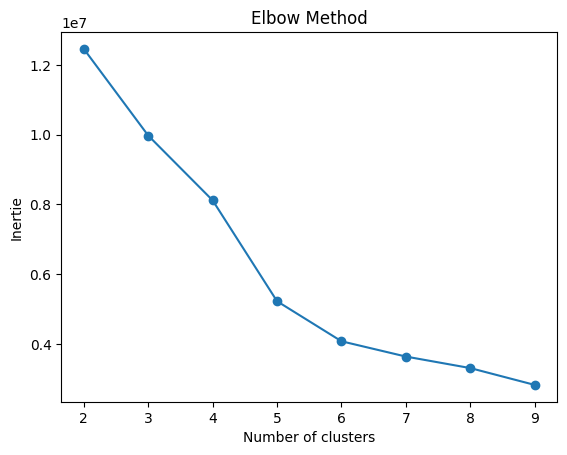

In [61]:
inertia = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertie")
plt.title("Elbow Method")
plt.show()

Étape 5 : Entraînement du modèle KMeans et attribution des clusters
Explication :

Après avoir déterminé le nombre optimal de clusters grâce à la méthode du coude, on entraîne le modèle KMeans. 
Les clusters obtenus sont stockés dans la variable clusters. On ajoute ensuite ces clusters au DataFrame features via une nouvelle colonne cluster.
Cela permet d’identifier à quel groupe appartient chaque observation et d’analyser les caractéristiques des différents clusters.

In [62]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)



Étape 6 : Évaluation du clustering avec le Silhouette Score
Explication :

On évalue la qualité du clustering à l’aide du Silhouette Score. Pour éviter un calcul trop lourd sur un dataset volumineux, on utilise le paramètre sample_size=5000, qui permet d’évaluer le score sur un échantillon aléatoire proposé par sklearn.

Le score obtenu permet de vérifier si le nombre de clusters choisi est cohérent.

In [63]:
score = silhouette_score(X_scaled, clusters, sample_size=5000, random_state=42)
print("Silhouette Score:", score)

Silhouette Score: 0.3008043861424315


Étape 7 : Visualisation des clusters avec la PCA
Explication :

On applique une réduction de dimension à l’aide de la méthode PCA. 

On observe une séparation relativement claire entre les groupes :
- Un cluster regroupe les observations avec des valeurs plus faibles.
- Un autre cluster regroupe des observations intermédiaires.
- Un troisième cluster correspond aux valeurs les plus élevées.

La structure montre que KMeans a réussi à identifier des groupes distincts selon l’intensité et la distribution des pathologies.

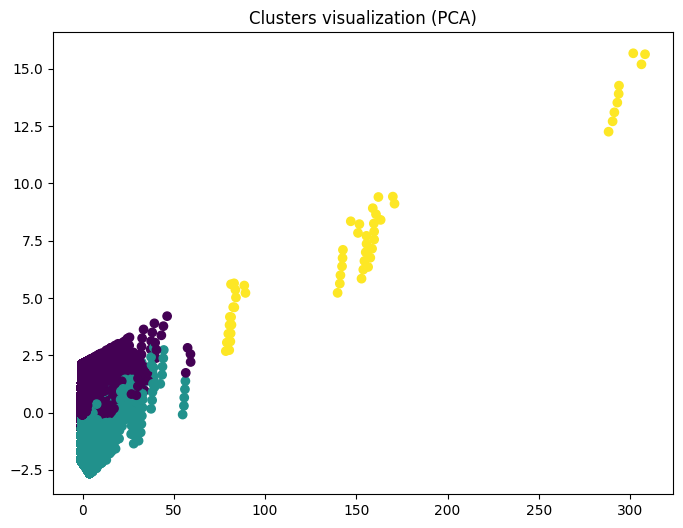

In [64]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis")
plt.title("Clusters visualization (PCA)")
plt.show()

Étape 8 : Création et sauvegarde de la pipeline non supervisée
Explication :
Creation d'une pipline supervisé (utile pour la partie api). En effet le Le fichier .pkl generé peut être directement chargé dans FastAPI

In [65]:
unsupervised_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=3, random_state=42, n_init="auto"))
])

unsupervised_pipeline.fit(features)

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..")) 
MODEL_DIR = os.path.join(BASE_DIR, "model")

os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "kmeans.pkl")

joblib.dump(unsupervised_pipeline, model_path)

loaded_model = joblib.load(model_path)

print("fichier crée a l'emplacement:",model_path )

fichier crée a l'emplacement: c:\Users\Rayan TOUMERT\Downloads\pathology-evolution-prediction\model\kmeans.pkl


Conclusion : Modélisation non supervisée

Le modèle KMeans a permis d’identifier trois groupes distincts de régions et d’années selon l’intensité des pathologies (volume de cas et prévalence).
La visualisation PCA montre une séparation relativement claire entre les clusters, ce qui indique que le modèle parvient à structurer les données en groupes cohérents.
Cependant, le Silhouette Score obtenu (environ 0.30) reste modéré. Cela signifie que :
- La séparation entre les clusters n’est pas parfaitement nette
- Certains groupes se chevauchent
- La structure des données n’est pas fortement segmentée

Les limites :
- Le choix du nombre de clusters influence fortement les résultats
- Le clustering ne permet pas de prédire une valeur future (contrairement au modèle supervisé)
- L’interprétation métier des clusters peut rester limitée sans analyse complémentaire

Conclusion : Modélisation non supervisée (Analyse Business)

Le modèle KMeans a permis d’identifier trois profils distincts de régions en fonction de l’intensité des pathologies.

Cette segmentation permet de mieux comprendre les différences territoriales et d’identifier des groupes de régions présentant des dynamiques similaires.